# MDBA Machine Learning Notebook

Annotating and training an object detector for automated counting of species

IMPORTANT NOTE: Parameters in params.yaml are used throughout the notebook.

The paths used throughout the notebook are relative and therefore the working directory must be the root of the machine learning directory. E.g.

<ul>
<li>Root</li>
    <ul>
    <li>Data</li>
    <li>Models</li>
    <li>Scripts</li>
    <li>Utils</li>
    <li>requirements.txt</li>
    <li>params.yaml</li>
    <li>README.pdf</li>
    <li>README.md</li>
    </ul>
</ul>


In [11]:
!python --version

Python 3.8.5


In [ ]:
# Set working directory here
os.chdir(r'/home/azureuser/cloudfiles//code/Users/Ahsanul.Habib/WaterbirdCount/Drone-based-waterbird-counting')
os.getcwd()
!export PYTHONPATH=$rootfolder

In [10]:
import sys, os
import argparse
import re
import csv
import cv2
import codecs, json
from json import JSONEncoder
from tqdm import tqdm
from pathlib import Path
from random import seed, shuffle, sample
from shutil import copyfile, move
from subprocess import run, Popen
import yaml
from yaml import safe_load
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import gc
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from utils.train_utils import collate_fn, get_transform, BirdDataset
from utils.Slicer import Slicer
from utils.utils import ensure_path
from utils.data_utils import CocoDataset
from utils.utils import str2bool
from utils.count import count_folder

from scripts.prepare_training_set import save_slices, cocofy_annotations, prepare_training_set
from scripts.split_raw_dataset import split_dataset, generate_training_set
from scripts.train_mdba import train_loop_fn, eval_loop_fn, train_mdba
from scripts.eval_mdba import save_holdout_slices_with_inferences, save_inference_results, groundTruth_annotations, draw_bboxes_save_results

In [5]:
with open('./params.yaml', 'r') as params_file:
        params = yaml.safe_load(params_file)
# print(params)

# Split raw dataset 

This module takes raw images and a point file created in dotdotgoose to split them into appropriate size slices for training.

Slice size, as well as raw image size must be specified in the .yaml read in in the 2nd code chunk.

The slices are automatically placed into a new directory to be ingested by the 'prepare_training_set.py' module

### Function definitions

In [11]:
def _save_slices(params, slice_dict, input_dict, input_dir, output_dir, datatype):
    """
    This function takes a list of inputs, and for each input does the following:
        - Reads the file as an image
        - For each slice in slice_set, crops the image and saves the output
    """    
    # Generate and save slices for each file in input dictionary
    
    output_dir = ensure_path(output_dir)
    for filename, slice_set in tqdm(input_dict.items(), desc=f"Saving {datatype} slices"):
        img = cv2.imread(str(input_dir/filename))
        for slice_id in slice_set:
            l,t,r,b = slice_dict[slice_id]
            slice = img[t:b, l:r]
            slicename = (os.path.splitext(filename)[0] + f"_t{t:04d}_b{b:04d}_l{l:04d}_r{r:04d}.jpg")
            slicepath = str(Path(output_dir) / slicename)
            cv2.imwrite(slicepath, slice)
            if datatype == 'trainval':
                cv2.imwrite(str(Path(params['training']['train_data_dir'])/params['data']['project_name']/'sliced_images'/slicename), slice)

In [124]:
def split_dataset(params, project_dir, points_dict, trainval_dir, holdouts_dir, nolabels_dir, *args):
    """
    This function is the main workhorse in reading the raw project folder
    and splitting it up into training, holdout, and nolabels sub-folders.
    """
    # Use the holdouts ratio defined in params.yaml to split the dataset
    holdouts_ratio = params['data']['holdouts_ratio']

    # Create the folders, if they do not already exist
    for path in [trainval_dir, holdouts_dir, nolabels_dir]:
        ensure_path(path)

    # Separate all images without annotation data
    noannotation_filenames = args[0]
    withannotation_filenames = {}
    for filename, _ in tqdm(points_dict.items(), desc="Filtering out images with missing annotation data"):
        if filename not in noannotation_filenames:
            withannotation_filenames[filename] = points_dict[filename]
        
    # Separate all files into empty and nonempty files, saving the former into the nolabels folder
    nonempty_filenames = []
    for filename, _ in tqdm(withannotation_filenames.items(), desc="Filtering out empty images"):
        points = withannotation_filenames[filename]
        if len(points) == 0:
            copyfile(project_dir/filename, nolabels_dir/filename)
        else:
            copyfile(project_dir/filename, trainval_dir/filename)
            nonempty_filenames.append(filename)

    # For all remaining (nonempty) files, split them up into training set and holdout set
    seed(1)
    shuffle(nonempty_filenames)
    nonempty_size = len(nonempty_filenames)
    holdouts_size = int(holdouts_ratio*nonempty_size)
    holdouts_set = nonempty_filenames[:holdouts_size]

    # This is where files are actually moved out of the trainval folder into the holdout folder
    for filename in tqdm(holdouts_set, desc="Creating holdouts set"):
        move(trainval_dir/filename, holdouts_dir/filename)

    return holdouts_set, withannotation_filenames

In [6]:
def generate_training_set(params, points_dict, holdouts_set, 
                          trainval_input_dir, holdouts_input_dir,
                          trainval_output_dir, holdouts_output_dir):
    """
    Once the dataset has been separated into trainval, holdout and nolabels directories,
    this function splits each image inside the trainval and holdout directories into pieces (slices).
    Saving those slices into respective folders is done in preparation for data labelling.
    """
    
    # Initialise image and slice dimensions
    image_height = params['data']['image_height']
    image_width = params['data']['image_width']
    slice_height = params['slices']['height']
    slice_width = params['slices']['width']

    sl = Slicer(h=image_height, w=image_width, dh=slice_height, dw=slice_width)
    slice_dict = sl.get_slice_dict()
    
    trainval_sliced_dict = {}
    holdouts_sliced_dict = {}
    for img_id, coords_dict in tqdm(points_dict.items(), desc="Creating slices dictionary"):
        if img_id not in holdouts_set:
            slice_list = []
            for _, pts in coords_dict.items():
                for pt in pts:
                    slice_id = sl.get_slice_id_from_point(pt)
                    slice_list.append(slice_id)
            slice_set = set(slice_list)
            if slice_set:
                trainval_sliced_dict[img_id] = slice_set
        else:
            slice_list = []
            slice_set = set(slice_dict.keys())
            holdouts_sliced_dict[img_id] = slice_set

    _save_slices(params, slice_dict, trainval_sliced_dict, trainval_input_dir, trainval_output_dir, datatype='trainval')
    _save_slices(params, slice_dict, holdouts_sliced_dict, holdouts_input_dir, holdouts_output_dir, datatype='holdouts')

### Module execution

In [12]:
# Initialise all required variables
raw_dir = Path(params['data']['raw_dir'])
project_name = params['data']['project_name']
project_folder = raw_dir / project_name
points_file = [file for file in os.listdir(project_folder) if file.endswith('.pnt')][0]
points_path = project_folder / points_file

holdouts_dir = Path(params['data']['holdouts_dir'])/(project_name+'_v1')
filenames = sorted(os.listdir(holdouts_dir))
no_annotation = [filename for filename in filenames if filename.lower().endswith('.jpg')]

trainval_dir = Path(params['data']['trainval_dir'])/project_name
holdouts_dir = Path(params['data']['holdouts_dir'])/project_name
nolabels_dir = Path(params['data']['nolabels_dir'])/project_name
trainval_output_dir = Path(params['slices']['trainval_dir'])/project_name/'sliced_images'
holdouts_output_dir = Path(params['slices']['holdouts_dir'])/project_name/'sliced_images'

# The .pnt file is necessary to prepare a training set.
# Otherwise the number of slices quickly becomes intractable.
points_file = [file for file in os.listdir(project_folder) if file.endswith('.pnt')][0]
points_path = project_folder / points_file
try:
    with open(points_path) as file:
        data = file.read()
        data = json.loads(data)
        points_dict = data.get('points')
except FileNotFoundError as err:
    print(f"{err}")
    raise
except NameError as err:
    print(f"{err}")
    print(f"Ensure that the .pnt file is properly formatted")
    raise

# First split the raw images into categories: trainval, holdouts, nolabels
holdouts_set, updated_points_dict = split_dataset(params, raw_dir / project_name, points_dict, trainval_dir, holdouts_dir, nolabels_dir, no_annotation)
points_dict = updated_points_dict
# Then, for the trainval and holdouts datasets, split them up and save the slices that have been identified by the .pnt file as containing objects. 
# This is done to filter out empty slices and reduce the labelling required for building a detector.
generate_training_set(params, points_dict, holdouts_set, trainval_dir, holdouts_dir, trainval_output_dir, holdouts_output_dir)

Filtering out images with missing annotation data: 100%|██████████| 205/205 [00:00<00:00, 1176241.20it/s]
Saving holdouts slices: 100%|██████████| 15/15 [02:58<00:00, 11.90s/it]


# Start label studio

Please note that this code will only run using a bash or zsh shell

In [4]:
def start_labeling_job(trainval_dir):
    cmd = ["chmod", "+x", "./scripts/get_urls.sh"]
    run(cmd)

    cmd = ["./scripts/get_urls.sh", f"{trainval_dir}", "*.jpg"]
    Popen(cmd)

    cmd = ["label-studio", "start"]
    Popen(cmd)

# Prepare training set

This script is used to scan through labels produced from label studio 
and prepare a dataset in the COCO format required for training.

### Function definitions

In [14]:
def save_slices(filepath, slice_ids, slice_dict, output_dir):
    """
    This function loads an image, slices it up, and saves the pieces (slices) as separate images.
    It returns the paths of each slice as a list.
    """
    img = cv2.imread(filepath)
    filename = os.path.basename(filepath)
    slicepaths = []
    for slice_id in slice_ids:
        l,t,r,b = slice_dict[slice_id]
        slice = img[t:b, l:r]
        slicename = (os.path.splitext(filename)[0] + f"_t{t:04d}_b{b:04d}_l{l:04d}_r{r:04d}.jpg")
        slicepath = str(Path(output_dir) / slicename)
        cv2.imwrite(slicepath, slice)
        slicepaths.append(slicepath)
    return slicepaths

In [14]:
def cocofy_annotations(data_dir, labels, *args):
    """
    This function is used to reformat the annotations from label-studio into that required for training.

    Inputs:
        - data_dir: Data directory where original slice is located
        - labels: Label-studio annotations

    Outpus:
        - annotations: Dictionary containing COCO formatted annotations
    """
    
    excluded_images = args[0]
    # trainval_images = args[1]
    annotations = {}
    for label in labels:
        lbl_annotations = label['annotations'][0]
        if not lbl_annotations['was_cancelled']:
            # This if statement is meant to deal with issues that may arise with label studio if saving over a project
            if len(lbl_annotations['result'])==0 and lbl_annotations.get('prediction'):
                old_result = lbl_annotations['prediction']['result']
                lbl_annotations['result'] = old_result if len(old_result) > 3 else lbl_annotations['result']
            
            # Convert label studio annotations to COCO format
            old_bbox_data = lbl_annotations['result']
            coco_bbox_data = []
            for bbox in old_bbox_data:
                old_bbox = bbox['value']
                coco_bbox = [old_bbox['x']/100, old_bbox['y']/100, old_bbox['width']/100, old_bbox['height']/100]
                coco_label = old_bbox['rectanglelabels'][0]
                coco_bbox_datum = {'bbox': coco_bbox, 'label': coco_label}
                coco_bbox_data.append(coco_bbox_datum)

            filename = os.path.basename(label['data']['image'])
            if not any([file for file in excluded_images if file.split('.JPG')[0] in filename]):
                annotations[str(Path(data_dir) / filename)] = coco_bbox_data
    return annotations

In [16]:
def prepare_training_set(params):
    """
    This function scans through the labels produced from label studio 
    and prepares a dataset in a format required for training

    Inputs: params (see params.yaml)

    Outputs: a dataset in COCO format located in training->train_coco (see params.yaml)
    """
    
    # Initialise required variables (see params.yaml)
    train_data_dir = ensure_path('./'+str(Path(params['training']['train_data_dir'])/params['data']['project_name']/'sliced_images'))
    train_coco = params['training']['train_coco']
    project_name = params['data']['project_name']
    nolabels_dir = Path(params['data']['nolabels_dir'])/project_name
    
    holdouts_dir0 = Path(params['data']['holdouts_dir'])/(project_name)
    holdouts_dir1 = Path(params['data']['holdouts_dir'])/(project_name+'_v1')
    
    filenames_ho = sorted(os.listdir(holdouts_dir0))
    filenames_na = sorted(os.listdir(holdouts_dir1))
    
    no_annotation = [filename for filename in filenames_na if filename.lower().endswith('.jpg')]
    holdoutimages = [filename for filename in filenames_ho if filename.lower().endswith('.jpg')]
    
    slices_trainval_dir = Path(params['slices']['trainval_dir'])/project_name/'sliced_images'
    slices_nolabels_dir = Path(params['slices']['nolabels_dir'])/project_name/'sliced_images'

    image_height = params['data']['image_height']
    image_width = params['data']['image_width']
    slice_height = params['slices']['height']
    slice_width = params['slices']['width']

    # This labels variable is the filepath containing the output of the label-studio labelling job.
    labels = params['slices']['labels']

    # This function transforms, or re-formats, the labels into the required format for training.
    with open(labels, 'r') as fr:
        annotations = cocofy_annotations(slices_trainval_dir, json.loads(fr.read()), no_annotation+holdoutimages)

    # This function adds the new annotations to a dataset ready for training
    coco_dataset = CocoDataset(train_data_dir)
    coco_dataset.add_existing_annotations(annotations)

    # This loop scans through the empty images (those containing no labels), slices them up, then
    # subsamples a few slices to include in the training set to reduce False Positive Rate.
    sl = Slicer(h=image_height, w=image_width, dh=slice_height, dw=slice_width)
    slice_dict = sl.get_slice_dict()
    output_dir = ensure_path(slices_nolabels_dir)
    i = 0
    for filename in tqdm(os.listdir(nolabels_dir), desc="Adding negative samples"):
        i+=1
        seed(i)
        filepath = str(Path(nolabels_dir) / filename)
        slice_ids = sample(list(slice_dict), 3)
        slicepaths = save_slices(filepath, slice_ids, slice_dict, output_dir)
        coco_dataset.add_negative_samples(slicepaths)
    
    # The dataset is exported into a format ready for training
    coco_dataset.export_dataset(train_coco)

### Module execution

In [17]:
prepare_training_set(params)

Adding negative samples: 100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


# Train model

### CNN library imports

In [5]:
import gc
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from utils.train_utils import collate_fn, get_transform, BirdDataset

### Function definitions

In [19]:
def train_loop_fn(data_loader, model, optimizer, device, scheduler=None):
    """
    This is the "training loop", which calculates the loss for each epoch
    """
    running_loss = 0.0
    for images, labels, filenames in tqdm(data_loader, desc="Training"):
        images = list(image.to(device) for image in images)
        labels = [{k: v.to(device) for k, v in l.items()} for l in labels]
        # print(labels)
        optimizer.zero_grad()
        loss_dict = model(images, labels)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
        del images, labels
        gc.collect()
        torch.cuda.empty_cache()
    train_loss = running_loss / float(len(data_loader))
    scheduler.step(train_loss)
    return train_loss

In [20]:
def eval_loop_fn(data_loader, model, device):
    """
    This is the "validation loop", which calculates the loss for each epoch
    """
    running_loss = 0.0
    for images, labels, filenames in tqdm(data_loader, desc="Validation"):
        images = list(image.to(device) for image in images)
        labels = [{k: v.to(device) for k, v in l.items()} for l in labels]
        loss_dict = model(images, labels)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        del images , labels
        gc.collect()
        torch.cuda.empty_cache()
    valid_loss = running_loss / float(len(data_loader))
    return valid_loss

In [21]:
def train_mdba(params):
    """
    This is the main function that actually performs the training.

    Inputs: params from params.yaml file

    Outputs: a best model is saved in the best_model_path
    """

    # Define training parameters, typically no need to change these
    lr = params['training']['learning_rate']
    wd = params['training']['weight_decay']
    momentum = params['training']['momentum']
    early_stopping_patience = params['training']['early_stopping_patience']
    num_epochs = params['training']['num_epochs']

    best_model_path = Path(params['models']['best_model']) # Where output model will be saved
    ensure_path(params['models']['weights_dir']) # Ensure the output model folder exists

    # Define the dataset using training transforms (see ./utils/train_utils.py)
    # NOTE: it may be useful to split train and validation transforms before this step
    my_dataset = BirdDataset(
        root=params['training']['train_data_dir'],
        annotation=params['training']['train_coco'],
        transforms=get_transform())

    # Split the dataset into training and validation sets
    val_ratio = params['training']['val_ratio']
    total_size = len(my_dataset)
    val_size = int(val_ratio*total_size)
    train_size = total_size-val_size
    train_dataset, valid_dataset = torch.utils.data.random_split(
        my_dataset, (train_size, val_size))

    # Define data loaders for training and validation sets
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=params['training']['train_batch_size'],
        shuffle=True,
        num_workers=params['training']['num_workers_dl'],
        collate_fn=collate_fn)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=params['training']['valid_batch_size'],
        shuffle=False,
        num_workers=params['training']['num_workers_dl'],
        collate_fn=collate_fn)

    # Load the model into memory
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)

    # Define optimizer and scheduler
    model_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(model_params, lr=lr, momentum=momentum, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    # Run main training loop, save a model when an epoch outperforms previous best
    all_losses = []
    for epoch in range(num_epochs):
        print(f"Epoch --> {epoch+1} / {num_epochs}")
        print(f"-------------------------------")
        train_loss = train_loop_fn(train_loader, model, optimizer, device, scheduler)
        print('training Loss: {:.4f}'.format(train_loss))
        valid_loss = eval_loop_fn(valid_loader, model, device)
        print('validation Loss: {:.4f}'.format(valid_loss))
        all_losses.append(valid_loss)
        
        ## Uncomment this line to save model after every epoch
        # torch.save(model, f"{weights_dir}/epoch-{epoch}_lr-{lr}.pth")

        if epoch == 0: # Save model as "best model" after first epoch
            torch.save(model, best_model_path)
            best_loss = valid_loss
            best_epoch = epoch
        elif valid_loss < best_loss: # Save model as "best model" if it results in lower loss
            torch.save(model, best_model_path)
            best_loss = valid_loss
            best_epoch = epoch
        elif epoch - best_epoch == early_stopping_patience: # Stop if no progress has been made
            print(f"Early stopping condition reached. Stopping training.")
            break

### Module Execution

In [24]:
train_mdba(params)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
Epoch --> 1 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.5051


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.20it/s]


validation Loss: 0.3892
Epoch --> 2 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:59<00:00,  1.77s/it]


training Loss: 0.3639


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3705
Epoch --> 3 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.76s/it]


training Loss: 0.3454


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3554
Epoch --> 4 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.76s/it]


training Loss: 0.3326


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3474
Epoch --> 5 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.76s/it]


training Loss: 0.3219


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3458
Epoch --> 6 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.3138


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.22it/s]


validation Loss: 0.3438
Epoch --> 7 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.3055


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3472
Epoch --> 8 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2980


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.22it/s]


validation Loss: 0.3438
Epoch --> 9 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.76s/it]


training Loss: 0.2898


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.22it/s]


validation Loss: 0.3486
Epoch --> 10 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.76s/it]


training Loss: 0.2841


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3514
Epoch --> 11 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2776


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.22it/s]


validation Loss: 0.3490
Epoch --> 12 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2707


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.22it/s]


validation Loss: 0.3518
Epoch --> 13 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2652


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3514
Epoch --> 14 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2586


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3594
Epoch --> 15 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2537


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3627
Epoch --> 16 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2478


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3616
Epoch --> 17 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2406


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3613
Epoch --> 18 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2352


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3671
Epoch --> 19 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2303


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3600
Epoch --> 20 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2249


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3658
Epoch --> 21 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:58<00:00,  1.77s/it]


training Loss: 0.2193


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3750
Epoch --> 22 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:59<00:00,  1.77s/it]


training Loss: 0.2151


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3688
Epoch --> 23 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:59<00:00,  1.77s/it]


training Loss: 0.2100


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3757
Epoch --> 24 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:59<00:00,  1.77s/it]


training Loss: 0.2058


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.21it/s]


validation Loss: 0.3775
Epoch --> 25 / 25
-------------------------------


Training: 100%|██████████| 203/203 [05:59<00:00,  1.77s/it]


training Loss: 0.2011


Validation: 100%|██████████| 101/101 [00:45<00:00,  2.22it/s]

validation Loss: 0.3772


# Count birds with trained model

After a model has been trained to count species, this script performs the counting.
It does so by calling a function within ./utils/count.py that slices images then feeds
these slices into the model, one by one, before tallying up the counts and outputting them.

Results are saved in an output folder defined below (./model/results by default).

Necessary inputs (see params.yaml file for defaults):
<ul>
    <li>data-root: Root directory (usually ./data/raw) where projects (folders) containing raw images is stored </li>
    <li>project-name: Name of the folder where raw images are stored, which will act as inputs for prediction.</li>
    <li>image-height: This is the height (in pixels) of raw images (must be consistent across all images).</li>
    <li>image-width: This is the width (in pixels) of raw images (must be consistent across all images).</li>
    <li>slice-height: This is the height (in pixels) of individual slices. These slices are used for inference.</li>
    <li>slice-width: This is the width (in pixels) of individual slices. These slices are used for inference.</li>
    <li>overlap: Vertical overlap ratio between adjacent images. Depends on the mission.</li>
    <li>sidelap: Horizontal overlap ratio between adjacent images. Depends on the mission.</li>
    <li>categories: Categories to detect. See example function call above to deal with multiple categories.</li>
        <ul>
        <li>-- NOTE: If using customised categories (not recommended!):</li>
            <ul>
            <li>number of categories must match the number that the model was trained against</li>
            <li>categories must be a list of dictionaries with this format:</li>
            </ul>
                <ul>
                <li>- e.g. [
                    {'id': 0, 'name': 'bird', 'supercategory': 'animal'},
                    {'id': 1, 'name': 'dog', 'supercategory': 'animal'},
                ]</li>
                </ul>
        </ul>
</ul>

Optional inputs (see params.yaml file for defaults)
<ul>
    <li>output-folder: This is the folder where outputs will be stored.</li>
    <li>conf-thresh: Binary cut-off threshold for detection. Can be used to calibrate for under/overcounting.</li>
    <li>stride: Lower values increase computational time for improved performance. Must be > 0 and <=1.</li>
    <li>model-path: Model file path. Either update the params.yaml file or the default one in this function.</li>
    <li>save-slices: Setting this argument to True saves all the individual slices (inputs). Useful for analysis.</li>
</ul>

Outputs:
<ul>
    <li>Look for outputs in the value defined in params.yaml (evaluation->results_dir) or define a new location here.</li>
</ul>

### Module execution

In [22]:
# find root location useing this notebook's location and set a project folder to get images from and save results to
import os as os
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
rootfolder = ipynb_path.removesuffix("/notebooks")
if (rootfolder.startswith("/mnt")): # if using mounted storage in AzureML we need to point to the local path
    import re
    m = re.search("/clusters/[^/]*(.*)", rootfolder)
    rootfolder ="/home/azureuser/cloudfiles/" + m.group(1)
    print(rootfolder)
projectfolder = 'testproject'

os.chdir(rootfolder)

/home/azureuser/cloudfiles//code/Users/Ahsanul.Habib/WaterbirdCount/Drone-based-waterbird-counting


In [ ]:
script = rootfolder + "/scripts/bird_count.py" 
%run $script

# Evaluate trained model

If ground truth counts are provided, this module performs linear regression using predicted and manual counts as input

There are two outputs:
<ul>
    <li> A csv containing the predicted and manual counts </li>
    <li> A .png figure of the linear regression labelled with the equation and r-squared</li>
</ul>

In [29]:
def eval_mdba(params):
    """
    This function takes the project name in params.yaml as a parameter, then runs
    an inference over all the slices (images) in the holdout set for that project.
    """

    # Initialise inputs
    project_name = params['data']['project_name']
    slice_holdout_dir = Path(params['slices']['holdouts_dir'])/project_name/'sliced_images'
    results_dir = ensure_path(Path(params['evaluation']['results_dir']))
    conf_thresh = params['evaluation']['conf_thresh']

    # Load model
    model = torch.load(params['models']['best_model'])
    model.cuda()
    model.eval()
    transform = get_transform()

    # For each file in the holdout set, make a prediction and 
    # store the outputs in a dictionary called predictions
    predictions = {}
    filenames = sorted(os.listdir(slice_holdout_dir))
    img_ids = []
    first=True
    for filename in tqdm(filenames, desc="Counting birds in holdout set"):
        img_id = '_'.join(filename.split('_')[:3]) + '.JPG'
        if predictions.get(img_id) is None:
            predictions[img_id] = 0
            img_ids.append(img_id)
            if not first:
                print(f"Count for {prev_img_id} == {predictions[prev_img_id]}")
            first=False
        filepath = Path(slice_holdout_dir)/filename
        image = Image.open(filepath)
        image = transform(image).unsqueeze(0).cuda()

        # This line is where the actual "inference" occurs.
        # Write functionality after this line for customised analysis.
        # This variable is a dictionary with three keys: "boxes", "labels" and "scores".
        out = model(image)[0]

        scores = out['scores'].cpu().detach().numpy()
        predictions[img_id] += len(scores[scores>conf_thresh])
        prev_img_id = img_id
    
    print(f"Count for {prev_img_id} == {predictions[prev_img_id]}")
    ground_truth = {}
    ground_truth_data = params['data']['ground_truth_counts']
    with open(ground_truth_data, "r") as csv_file:
        gt_data = csv.reader(csv_file)
        for row in gt_data:
            if row[0] in img_ids:
                ground_truth[row[0]] = int(row[1])

    xs = []
    ys = []
    for key, value in predictions.items():
        xs.append(ground_truth[key])
        ys.append(value)

    xs = np.array(xs)
    ys = np.array(ys)

    xs_fit = xs[:,np.newaxis]
    a, res, _, _ = np.linalg.lstsq(xs_fit, ys, rcond=None)
    r2 = 1 - res / (ys.size * ys.var())

    # Output CSV and PNG
    output_basename = "true_vs_predicted_counts"
    dataset = pd.DataFrame({'MANUAL': xs, 'AUTOMATIC': ys}, columns=['MANUAL', 'AUTOMATIC'])
    dataset.to_csv(f"{results_dir}/{output_basename}.csv")

    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams.update({'font.size': 25})
    pylab.plot(xs,ys,'o')
    pylab.plot(xs,a*xs,"r--")
    plt.xlim(0.9,2200)
    plt.ylim(0.9,2200) 
    plt.ylabel('Predicted Count')
    plt.xlabel('True Count')
    plt.title('Comparing Ground Truth and Predicted Counts (Holdout Set)')
    plt.text(650, 750, f"y={a[0]:.3f}x," + " $\mathregular{R^{2}}$" + f"= {r2[0]:0.3f}", rotation = 27.5)
    plt.savefig(f"{results_dir}/{output_basename}.png")

### Module execution

In [218]:
# eval_mdba(params)

In [6]:
import os
import csv
import yaml
import torch
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from PIL import Image
from pprint import pprint
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops.boxes import box_iou

from utils.Slicer import Slicer
from utils.utils import ensure_path
from utils.train_utils import get_transform

In [7]:
from IPython.display import Image as IPyImage
from matplotlib import pyplot as plt

In [8]:
def setdiff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    return list(c - d)

In [9]:
def save_holdout_slices_with_inferences(parameters, slicename, boxes, Irec):
    if len(boxes) > 0:
        for i in range(len(boxes)):
            box = boxes[i].detach().cpu().numpy()
            (startX, startY, endX, endY) = box.astype("int")
            Irec = cv2.rectangle(Irec, (startX, startY), (endX, endY), (0,0,255), 2)
        output_folder = ensure_path(Path(parameters['inference']['results_dir'])/(parameters['data']['project_name'] + '_detections'))
        output_path = output_folder/f'{slicename}.jpg'
        cv2.imwrite(str(output_path), Irec)
        # plt.imshow(Irec)

In [10]:
def save_inference_results(out_folder, predictions):
    pred_filepath = out_folder/'inference_results.json'
    preds = []
    for l in range(len(predictions)):
        preds.append(dict(filepath=predictions[l]['filepath'],
                          boxes=predictions[l]['boxes'].numpy().tolist(),
                          scores=predictions[l]['scores'].numpy().tolist(),
                          labels=predictions[l]['labels'].numpy().tolist()
                         )
                    )
    json.dump(preds, codecs.open(pred_filepath, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

In [20]:
def groundTruth_annotations(params, data_dir, gt_annotation_pts, *args):
    """
    This function is used to reformat the annotations from label-studio into that required for training.

    Inputs:
        - data_dir: Data directory where original slice is located
        - labels: Label-studio annotations
        - args[0]: A list of excluded images

    Outpus:
        - annotations: Dictionary containing ground truth annotation
    """
    slice_height = params['slices']['height']
    slice_width = params['slices']['width']
    included_images = args[0]
    annotations = []
    for pts in tqdm(gt_annotation_pts, desc="Obtaining ground truth annotation for holdout set"):
        lbl_annotations = pts['annotations'][0]
        if not lbl_annotations['was_cancelled']:
            # This if statement is meant to deal with issues that may arise with label studio if saving over a project
            # if len(lbl_annotations['result'])==0 and lbl_annotations.get('prediction'):
            #     old_result = lbl_annotations['prediction']['result']
            #     lbl_annotations['result'] = old_result if len(old_result) > 3 else lbl_annotations['result']
            
            # Convert label studio annotations
            bbox_data = lbl_annotations['result']
            # coco_bbox_data = []
            boxes = []
            labels = []
            for bbox in bbox_data:
                orig_bbox = bbox['value']
                box = [orig_bbox['x']*slice_width/100, orig_bbox['y']*slice_height/100, (orig_bbox['x']+orig_bbox['width'])*slice_width/100, (orig_bbox['y']+orig_bbox['height'])*slice_height/100]
                label = 1 if orig_bbox['rectanglelabels'][0]=='bird' else 0
                # coco_bbox_datum = {'bbox': coco_bbox, 'label': coco_label}
                # coco_bbox_data.append(coco_bbox_datum)
                boxes.append(box)
                labels.append(label)
            filename = os.path.basename(pts['data']['image'])
            flag = [file for file in included_images if file.split('.JPG')[0] in filename]
            flag2 = filename in [file for file in included_images]
            # print(filename, flag, flag2)
            if flag2:
                annotations.append(dict(filepath=str(slices_holdout_dir/filename), 
                                        boxes=torch.tensor(boxes), 
                                        labels=torch.tensor(labels)
                                       )
                                  )
    return annotations

In [18]:
model = torch.load(params['models']['best_model'])
model.cuda()
model.eval()

transform = get_transform()
slices_holdout_dir = Path(params['slices']['holdouts_dir'])/params['data']['project_name']/'sliced_images'
filenames = sorted(os.listdir(slices_holdout_dir))

In [ ]:
inferences = []

for filename in tqdm(filenames, desc="Drawing boxes around birds in holdout set"):
    if not filename.startswith('.'):
        img_id = '_'.join(filename.split('_')[:3]) + '.JPG'; # print(img_id)
        raw_path = Path(params['data']['raw_dir'])/params['data']['project_name']/img_id; 
        regex = re.search("t(\d{4})..(\d{4})..(\d{4})..(\d{4})", filename)
        s_ids = regex.groups()
        t,b,l,r = tuple(int(s_id) for s_id in s_ids)
        raw_image = Image.open(raw_path);
        raw_slice = raw_image.crop((l,t,r,b)); 
        raw_slice_nparray = cv2.cvtColor(np.array(raw_slice)[:,:,::-1].copy(), cv2.COLOR_BGR2RGB)
        filepath = Path(slices_holdout_dir)/filename;
        image = Image.open(filepath)
        image = transform(image).unsqueeze(0).cuda() if torch.cuda.is_available() else transform(image).unsqueeze(0)
        out = model(image)[0]
        boxes = out['boxes'].cpu().detach().numpy()
        scores = out['scores'].cpu().detach().numpy()
        labels = out['labels'].cpu().detach().numpy()
        inferences.append(dict(filepath=str(filepath),
                                boxes=torch.tensor(boxes),
                                scores=torch.tensor(scores),
                                labels=torch.tensor(labels)
                           ))
        pred_boxes = out["boxes"]
        save_holdout_slices_with_inferences(params, filename, pred_boxes, raw_slice_nparray)
save_inference_results(output_folder, inferences)

In [21]:
no_annotation_dir = Path(params['data']['holdouts_dir'])/(params['data']['project_name']+'_v1')
train_data_dir = Path(params['training']['train_data_dir'])/params['data']['project_name']/'sliced_images'
included_filenames = sorted(os.listdir(slices_holdout_dir))
included_files = [filename for filename in included_filenames if filename.lower().endswith('.jpg')]

# This labels variable is the filepath containing the output of the label-studio labelling job.
labels_path = params['slices']['labels']
# This function transforms, or re-formats, the labels into the required format for training.
with open(labels_path, 'r') as fr:
    ground_truth = groundTruth_annotations(params, slices_holdout_dir, json.loads(fr.read()), included_files)

Obtaining ground truth annotation for holdout set: 100%|██████████| 2201/2201 [00:01<00:00, 2129.81it/s]


Drawing ground-truth and predicted boxes around birds in holdout set with available annotation data: 100%|██████████| 357/357 [03:05<00:00,  1.93it/s]


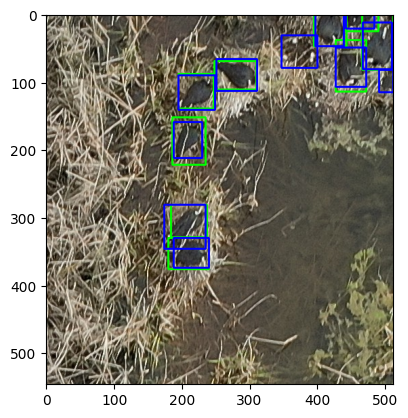

In [49]:
# gt_boxes = [ground_truth[i]['boxes'].cpu().detach().numpy() for i in range(len(ground_truth)) if ground_truth[i]['filepath'] in gt_path]
gt_filepaths = [ground_truth[i]['filepath'] for i in range(len(ground_truth))]
filenames = [os.path.basename(gt_filepaths[i]) for i in range(len(gt_filepaths))]
parameters = params
inferences = []
groundtruths = []
for filename in tqdm(filenames, desc="Drawing ground-truth and predicted boxes around birds in holdout set with available annotation data"):
    if not filename.startswith('.'):
        img_id = '_'.join(filename.split('_')[:3]) + '.JPG'
        raw_path = Path(params['data']['raw_dir'])/params['data']['project_name']/img_id
        regex = re.search("t(\d{4})..(\d{4})..(\d{4})..(\d{4})", filename)
        s_ids = regex.groups()
        t,b,l,r = tuple(int(s_id) for s_id in s_ids)
        raw_image = Image.open(raw_path);
        raw_slice = raw_image.crop((l,t,r,b)); 
        raw_slice_nparray = cv2.cvtColor(np.array(raw_slice)[:,:,::-1].copy(), cv2.COLOR_BGR2RGB)
        filepath = Path(slices_holdout_dir)/filename
        image = Image.open(filepath)
        image = transform(image).unsqueeze(0).cuda() if torch.cuda.is_available() else transform(image).unsqueeze(0)
        out = model(image)[0]
        boxes = out['boxes'].cpu().detach().numpy()
        scores = out['scores'].cpu().detach().numpy()
        labels = out['labels'].cpu().detach().numpy()
        boxes = boxes[scores > parameters['inference']['conf_thresh']]
        labels = labels[scores > parameters['inference']['conf_thresh']]
        scores = scores[scores > parameters['inference']['conf_thresh']]
        
        inferences.append(dict(filepath=str(filepath),
                                boxes=torch.tensor(boxes),
                                scores=torch.tensor(scores),
                                labels=torch.tensor(labels)
                           ))
        pred_boxes = out['boxes']; pred_scores = out['scores']
        gt_boxes = [ground_truth[i]['boxes'] for i in range(len(ground_truth)) if ground_truth[i]['filepath'] == str(filepath)][0]
        groundtruths.append(dict(filepath=str(filepath),
                                boxes=gt_boxes,
                                labels=torch.ones(len(gt_boxes))
                            ))
        # print(filepath, len(gt_boxes))
        Irec = raw_slice_nparray
        if len(gt_boxes) > 0:
            for j in range(len(gt_boxes)):
                gt_box = gt_boxes[j].detach().cpu().numpy()
                (startXg, startYg, endXg, endYg) = gt_box.astype("int")
                Irec = cv2.rectangle(Irec, (startXg, startYg), (endXg, endYg), (0,255,0), 2)
        # plt.imshow(Irec)
        if len(pred_boxes) > 0:
            for i in range(len(pred_boxes)):
                if pred_scores[i] > parameters['inference']['conf_thresh']:
                    box = pred_boxes[i].detach().cpu().numpy()
                    (startXp, startYp, endXp, endYp) = box.astype("int")
                    Irec = cv2.rectangle(Irec, (startXp, startYp), (endXp, endYp), (0,0,255), 2)
        # plt.imshow(Irec)
        slicename = filename
        output_folder = ensure_path(Path(parameters['inference']['results_dir'])/(parameters['data']['project_name'] + '_detections_available'))
        output_path = output_folder/f'{slicename}.jpg'
        cv2.imwrite(str(output_path), Irec)
        plt.imshow(Irec)

In [29]:
metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=list(np.linspace(0.5,0.95,101)), max_detection_thresholds=[1,10,100,1000,10000]) # list(np.linspace(0.5,0.95,101))
metric.update(inferences, groundtruths)
result = metric.compute()
pprint(result)

{'map': tensor(0.5824),
 'map_50': tensor(0.9286),
 'map_75': tensor(-1),
 'map_large': tensor(0.7613),
 'map_medium': tensor(0.5924),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.3123),
 'mar_1': tensor(0.0498),
 'mar_10': tensor(0.3455),
 'mar_100': tensor(0.6565),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.8089),
 'mar_medium': tensor(0.6697),
 'mar_small': tensor(0.4720)}


In [30]:
def align_coordinates(boxes):
    """Align coordinates (x1,y1) < (x2,y2) to work with torchvision `box_iou` op
    Arguments:
        boxes (Tensor[N,4])
    
    Returns:
        boxes (Tensor[N,4]): aligned box coordinates
    """
    x1y1 = torch.min(boxes[:,:2,],boxes[:, 2:])
    x2y2 = torch.max(boxes[:,:2,],boxes[:, 2:])
    boxes = torch.cat([x1y1,x2y2],dim=1)
    return boxes

In [3]:
def calculate_iou(gt, pr, form='pascal_voc'):
    """
    Calculates the Intersection over Union.
    Arguments:
        gt: (torch.Tensor[N,4]) coordinates of the ground-truth boxes
        pr: (torch.Tensor[M,4]) coordinates of the prdicted boxes
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
        IoU values for every element in boxes1 and boxes2
    """
    if form == 'coco':
        gt = gt.clone()
        pr = pr.clone()

        gt[:,2] = gt[:,0] + gt[:,2]
        gt[:,3] = gt[:,1] + gt[:,3]
        pr[:,2] = pr[:,0] + pr[:,2]
        pr[:,3] = pr[:,1] + pr[:,3]
    else:
        gt = align_coordinates(gt)
        pr = align_coordinates(pr)
    return box_iou(gt,pr)

In [1]:
def get_mappings(iou_mat):
    mappings = torch.zeros_like(iou_mat)
    gt_count, pr_count = iou_mat.shape
    
    #first mapping (max iou for first pred_box)
    if not iou_mat[:,0].eq(0.).all():
        # if not a zero column
        mappings[iou_mat[:,0].argsort()[-1],0] = 1

    for pr_idx in range(1, pr_count):
        # Sum of all the previous mapping columns will let 
        # us know which gt-boxes are already assigned
        not_assigned = torch.logical_not(mappings[:,:pr_idx].sum(1)).long()

        # Considering unassigned gt-boxes for further evaluation 
        targets = not_assigned * iou_mat[:,pr_idx]

        # If no gt-box satisfy the previous conditions
        # for the current pred-box, ignore it (False Positive)
        if targets.eq(0).all():
            continue

        # max-iou from current column after all the filtering will be the pivot element for mapping
        pivot = targets.argsort()[-1]
        mappings[pivot,pr_idx] = 1
    return mappings

In [33]:
def calculate_map(gt_boxes, pr_boxes, scores, thresh=0.5, form='coco'):
    # sorting
    pr_boxes = pr_boxes[scores.argsort().flip(-1)]
    iou_mat = calculate_iou(gt_boxes,pr_boxes,form) 
    
    # thresholding
    iou_mat = iou_mat.where(iou_mat>thresh, torch.tensor(0.))
    
    mappings = get_mappings(iou_mat)
    
    # mAP calculation
    tp = mappings.sum()
    fp = mappings.sum(0).eq(0).sum()
    fn = mappings.sum(1).eq(0).sum()
    mAP = tp / (tp+fp+fn)
    
    return mAP, iou_mat, tp, fp, fn

In [51]:
pred_boxes = []; pred_boxes = torch.cat([inferences[i]['boxes'] for i in range(len(inferences))], dim=0); len(pred_boxes)
pred_scores = []; pred_scores = torch.cat([inferences[i]['scores'] for i in range(len(inferences))], dim=0)
target_boxes = []; target_boxes = torch.cat([groundtruths[i]['boxes'] for i in range(len(groundtruths))], dim=0); len(target_boxes)

5393

In [54]:
mAP, iou, tp, fp, fn = calculate_map(target_boxes, pred_boxes, pred_scores, thresh=0.75)

In [55]:
mAP, tp, fp, fn

(tensor(0.6098), tensor(3896.), tensor(996), tensor(1497))